In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] 

from sklearn.cluster import KMeans
import os

# 分类颜色标识（可调）BGR格式
cluster_colors = {
    0: (0, 0, 255),   # 类别 0 （废矿） 用红色
    1: (0, 255, 0)    # 类别 1 用绿色
}

In [29]:
s = 'mean_hsv'

In [39]:
def rgb_to_hsv(rgb):
    color = np.uint8([[rgb]])  # 转换为 OpenCV 的格式
    hsv = cv2.cvtColor(color, cv2.COLOR_RGB2HSV)
    return hsv[0, 0]  # 返回 H, S, V


def plot_color_dis(color, results):
    rgb_array = np.array([r[color] for r in results])  # shape: (N, 3)
    R, G, B = rgb_array[:, 0], rgb_array[:, 1], rgb_array[:, 2]
    names = color.split('_')[1]
    plt.figure(figsize=(12, 4))

    # R
    plt.subplot(1, 3, 1)
    plt.hist(R, bins=30, color='red', alpha=0.7)
    plt.title("{} Channel Histogram".format(names[0].upper()))
    plt.xlabel("{} value".format(names[0].upper()))
    plt.ylabel("Count")

    # G
    plt.subplot(1, 3, 2)
    plt.hist(G, bins=30, color='green', alpha=0.7)
    plt.title("{} Channel Histogram".format(names[1].upper()))
    plt.xlabel("{} value".format(names[1].upper()))

    # B
    plt.subplot(1, 3, 3)
    plt.hist(B, bins=30, color='blue', alpha=0.7)
    plt.title("{} Channel Histogram".format(names[2].upper()))
    plt.xlabel("{} value".format(names[2].upper()))

    plt.tight_layout()

In [2]:
current_dir = os.getcwd()
code_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'codes'))
data_path = os.path.abspath(os.path.join(current_dir, '..', '..', 'data'))

# stack_image

In [ ]:
# 读取图像
img1 = cv2.imread(os.path.join(data_path, 'RGB_test/foo7.png'))
img2 = cv2.imread(os.path.join(data_path, 'RGB_test/foo8.png'))


img = np.vstack([img1[0:1230, :], img2])
cv2.imwrite(os.path.join(data_path, 'RGB_test/new.png'), img)  # 保存拼接后的图片

True

# find contours

In [21]:
# 读取图像
img = cv2.imread(os.path.join(data_path, 'RGB_test/new.png'))

min_area = 1000
max_area = 20000
bk = 3; clahe_clip = 11/10; clahe_tile = 8; canny_min = 73; canny_max = 135; close_kernel = 7 # 废矿轮廓也行的， 但是对边缘太敏感
# bk = 5; clahe_clip = 7/10; clahe_tile = 16; canny_min = 40; canny_max = 170; close_kernel = 7; #精矿轮廓很好

down_rate = 2

img_blurred = cv2.GaussianBlur(img, (bk, bk), 0)
img_down = cv2.resize(img_blurred, None, fx = 1/down_rate, fy = 1/down_rate)
img_gray = cv2.cvtColor(img_down, cv2.COLOR_BGR2GRAY)

# CLAHE 增强对比度
clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(clahe_tile, clahe_tile))
gray_enhanced = clahe.apply(img_gray)

# Canny边缘检测
edges = cv2.Canny(gray_enhanced, threshold1=canny_min, threshold2=canny_max)

# 形态学操作：closing
const1 = close_kernel 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (const1, const1))
edges_smoothed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=3)

# 查找轮廓
contours, _ = cv2.findContours(edges_smoothed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 面积过滤
filtered_contours = [cnt for cnt in contours if max_area > cv2.contourArea(cnt) > min_area and cv2.boundingRect(cnt)[3] < 500]

# 绘制轮廓
contour_img = img_down.copy()
cv2.drawContours(contour_img, filtered_contours, -1, (0, 255, 0), 2)

for i, cnt in enumerate(filtered_contours):

    # 计算质心
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        # 写编号
        cv2.putText(contour_img, str(i+1), (cx - 10, cy + 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 5)


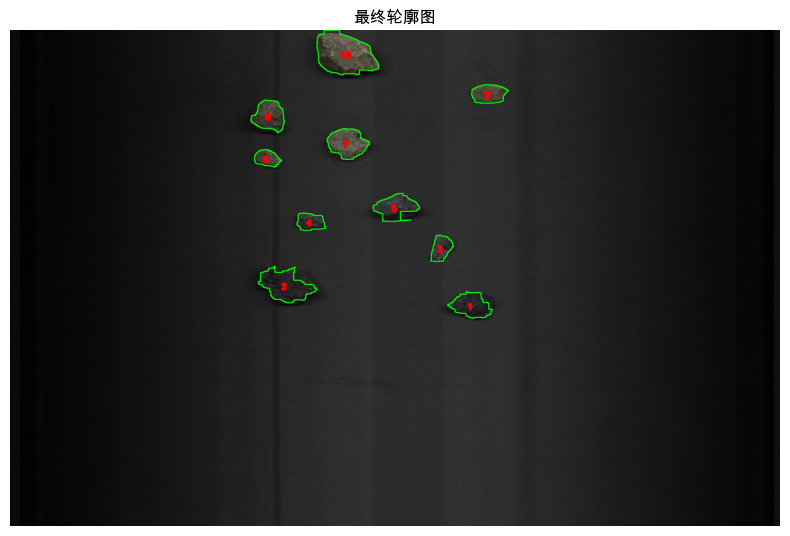

In [22]:

# 显示所有中间步骤
plt.figure(figsize=(8,6))
# plt.subplot(1, 5, 5)
plt.title("最终轮廓图")
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


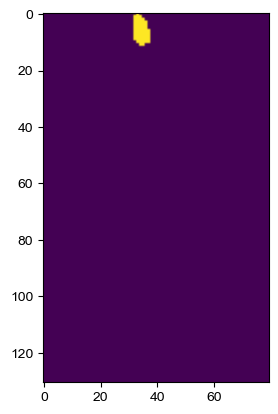

In [ ]:
cv2.resize(mask, (80, mask.shape[0]//10))

In [47]:
t = (mask.shape[0]/10, 80)

In [48]:
t

(131.9, 80)

In [23]:
results = []

for i, cnt in enumerate(filtered_contours):
    # 创建与原图同大小的黑色 mask
    mask = np.zeros(img_down.shape[:2], dtype=np.uint8)

    # 在 mask 上绘制当前轮廓，填充区域
    cv2.drawContours(mask, [cnt], -1, 255, -1)

    # 获取该轮廓对应的 RGB 像素（使用 mask 提取）
    masked_pixels = img_down[mask == 255]  # 这是一个 Nx3 的数组，每行为一个 RGB

    # 计算质心
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
    else:
        cx, cy = 0, 0

    # 保存
    results.append({
        "id": i,
        "centroid": (cx, cy),
        "pixels_rgb": masked_pixels,  # ndarray, shape: (N, 3)
        "mean_rgb": np.mean(masked_pixels, axis=0)  # 平均颜色，可选
    })

for r in results:
    mean_rgb = r["mean_rgb"]  # (R, G, B)
    # 注意 OpenCV 默认是 BGR
    mean_bgr = (mean_rgb[2], mean_rgb[1], mean_rgb[0])  # 转换为 BGR
    r["mean_hsv"] = rgb_to_hsv(mean_bgr)  # 例如：[H, S, V]
    # print(r['mean_hsv'])

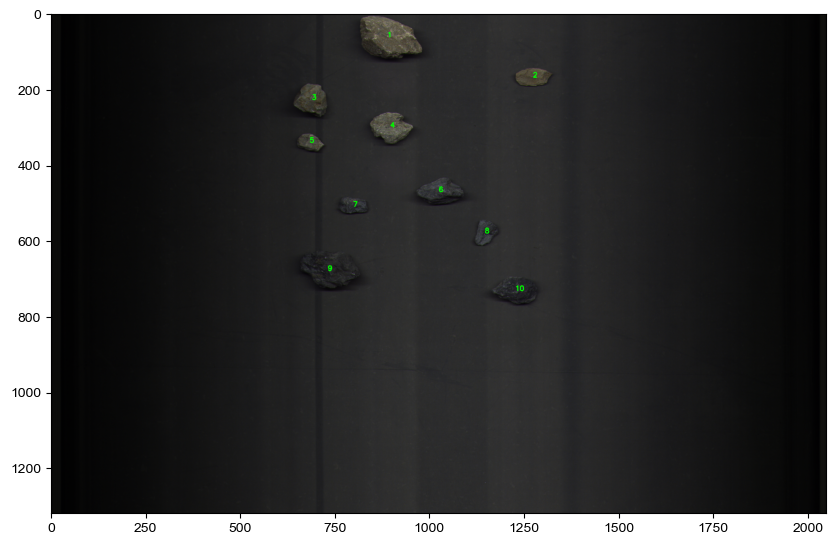

In [25]:
# 按质心的 y 坐标排序（从上往下）
results_sorted = sorted(results, key=lambda r: r["centroid"][1])

img_numbered = img_down.copy()

for idx, r in enumerate(results_sorted):
    cx, cy = r["centroid"]

    # 用绿色标注编号
    cv2.putText(img_numbered, str(idx + 1), (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_numbered, cv2.COLOR_BGR2RGB))

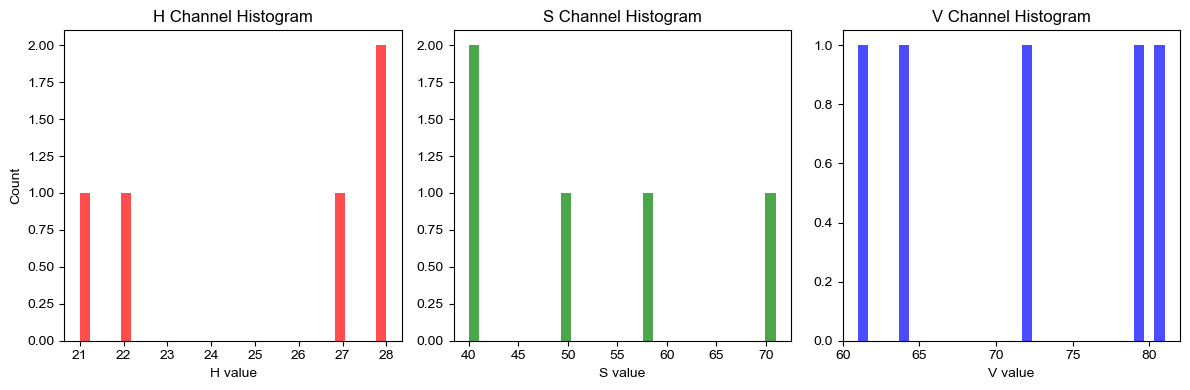

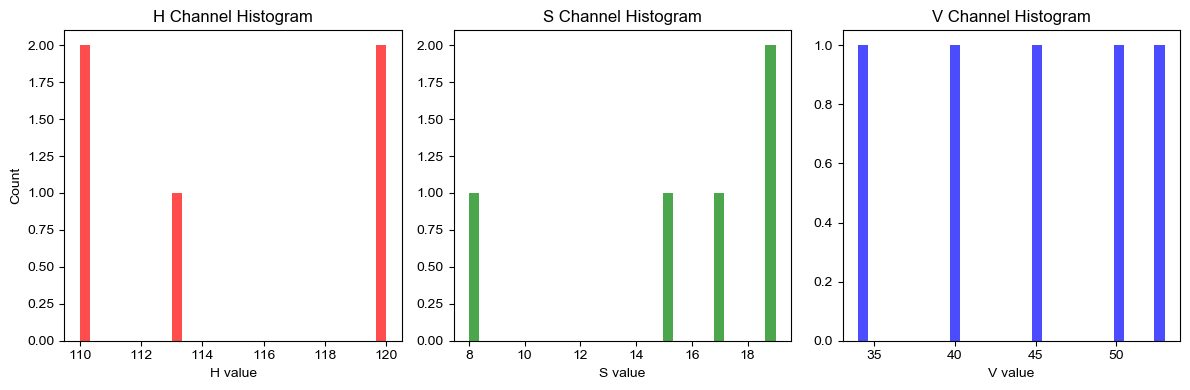

In [41]:
plot_color_dis('mean_hsv', results_sorted[0:5])
plot_color_dis('mean_hsv', results_sorted[5:])

### kmeans 分类

In [177]:
# 从结果中提取平均 RGB 向量
rgb_values = np.array([r["mean_hsv"] for r in results])  # shape: (N, 3)

# 设置聚类个数
num_clusters = 2

# 聚类
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto")
labels = kmeans.fit_predict(rgb_values)

# 将聚类结果加入原结果
for i, r in enumerate(results):
    r["cluster"] = int(labels[i])  # 转 int 避免 JSON 问题

# 打印各类别数量
from collections import Counter
print("聚类结果统计：", Counter(labels))

聚类结果统计： Counter({0: 19, 1: 17})


In [ ]:
# 复制一份图像
img_with_labels = img_down.copy()


for r, cnt in zip(results, filtered_contours):
    cx, cy = r["centroid"]
    cluster_id = r["cluster"]
    color = cluster_colors[cluster_id]

    # 绘制轮廓（不同类别用不同颜色）
    cv2.drawContours(img_with_labels, [cnt], -1, color, 2)

    # 标注类别编号
    label = f"C{cluster_id}"
    cv2.putText(img_with_labels, label, (cx, cy),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

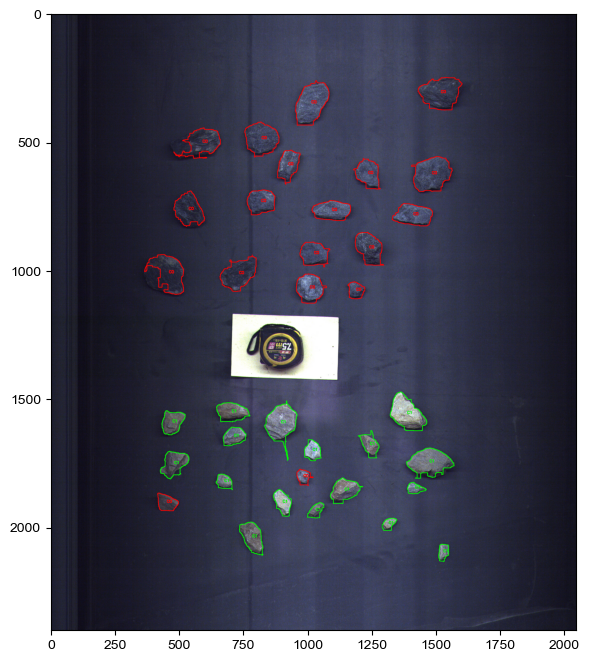

In [179]:
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_with_labels, cv2.COLOR_BGR2RGB))

### 颜色阈值分类

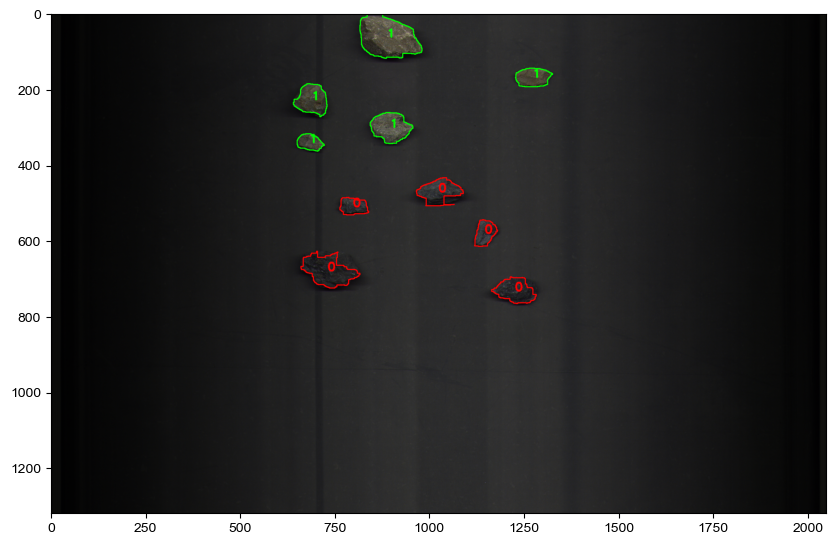

In [42]:
# 自定义分类规则
for r in results:
    H, S, V = r["mean_hsv"]

    if S > 30:
        r["class_by_color"] = 1
    else:
        r["class_by_color"] = 0
        
img_colorclass = img_down.copy()

for r, cnt in zip(results, filtered_contours):
    cx, cy = r["centroid"]
    cluster_id = r["class_by_color"]
    color = cluster_colors[cluster_id]

    label = f"{cluster_id}"
    cv2.drawContours(img_colorclass, [cnt], -1, color, 2)
    cv2.putText(img_colorclass, label, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_colorclass, cv2.COLOR_BGR2RGB))

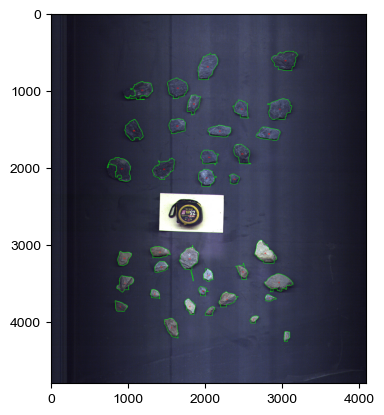

In [181]:
contour_img = img.copy()  # 原图

for i, cnt in enumerate(filtered_contours):
    # 映射轮廓坐标到原图
    cnt_scaled = cnt * 2

    # 绘制轮廓
    cv2.drawContours(contour_img, [cnt_scaled], -1, (0, 255, 0), 4)

    # 计算质心并映射
    M = cv2.moments(cnt_scaled)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        # 编号
        cv2.putText(contour_img, str(i + 1), (cx - 10, cy + 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

# 显示在原图上的编号轮廓图像
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))


轮廓总数：36
面积范围：1473.0 - 14999.5
平均面积：7120.4
中位数面积：6979.8


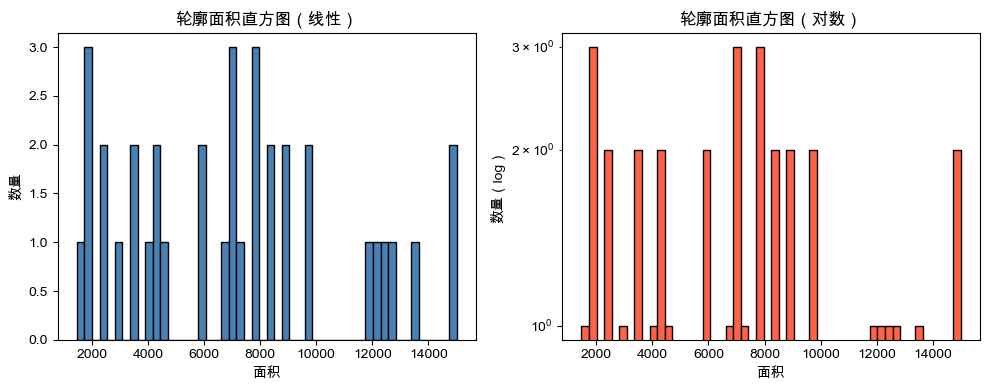

In [13]:
# 计算每个轮廓的面积
areas = [cv2.contourArea(cnt) for cnt in filtered_contours]

# 可选：过滤掉太小的值防止干扰直方图可视化
areas_filtered = [a for a in areas if a > 10]

# 统计信息
print(f"轮廓总数：{len(areas)}")
print(f"面积范围：{min(areas):.1f} - {max(areas):.1f}")
print(f"平均面积：{np.mean(areas):.1f}")
print(f"中位数面积：{np.median(areas):.1f}")

# 绘制面积直方图
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(areas_filtered, bins=50, color='steelblue', edgecolor='black')
plt.title("轮廓面积直方图（线性）")
plt.xlabel("面积")
plt.ylabel("数量")

plt.subplot(1, 2, 2)
plt.hist(areas_filtered, bins=50, log=True, color='tomato', edgecolor='black')
plt.title("轮廓面积直方图（对数）")
plt.xlabel("面积")
plt.ylabel("数量（log）")

plt.tight_layout()
plt.show()